## Project 2
Jacob Dirkx \
DSCI 311 - Principles & Techniques of Data Science \
Professor Muhlheisen \
4 December 2025

### Background & Data Overview
As someone who's double majoring with linguistics, I wanted to work with language data and challenge myself for this project. Beyond text data, I am interested in phonetics, so sought out acoustic data to work with for data analysis, inference, and prediction. After some searching, I came across SPREDS-D2.

SPREDS-2 (SPeech Recognition Evaluation Data Set - Discourse type 2) is a dataset of realistic, unscripted dialogue speech maintained by the Advanced Speech Technology Laboratory, a subset of the Universal Communication Research Institute of the National Institute of Information and Communications Technology of the Japanese Government. It is freely available to download from their [site](https://ast-astrec.nict.go.jp/en/release/SPREDS-D2/). I am using version 1.1. 

Once extracted, the data contains a `README`, a `LICENSE`, and three folders with data in Japanese, American English, and Mandarin Chinese. The data are comprised of audio recordings of real-time interviews conducted by professional interviewers with two to three experts per language.

Each folder/language has an `individual` subfolder, split into:

- **segmented** — interviews divided into many files, each corresponding to an unbroken utterance by a single speaker.
- **unsegmented** — one file corresponds to one interview (some duplicates).

Each folder/language also contains a `mixed` folder, which also contains one file per interview (without duplicates); I am not sure why there are duplicates in the `individual/unsegmented` folder.

Each of the `individual/segmented`, `individual/unsegmented`, and `mixed/` folders contains:

- `LABEL/` — `.label` files with transcriptions
- `WAVE/` — `.wav` files of the interviews

The general structure is as follows:

<pre>ver =[version number]
lang={01_jpn,02_eng,03_zho}

ver/
  00_doc/ 
  lang/
    individual/
      unsegmented/
         LABEL/
         WAVE/
      segmented/
         LABEL/
         WAVE/
    mixed/
      LABEL/
      WAVE/</pre>

For this project, I am just using individual/segmented files since they represent the finest granularity available in the dataset and they will be easier in inference.

Each language contains different lengths of total interview time:
- Japanese: 56:23
- English: 33:15
- Chinese: 36:11

### Methodology
With recordings of utterances in 3 languages, I then wanted to explore these language's phonetic inventories (what sounds/phones are present in the languages), and specifically their vowels. Vowels are frequently the nucleus of syllables (or syllable equivalents), so are important sounds for a speaker of a language. As a speaker of these languages, I find myself constructing implicit conceptualizations of their vowels as distinct systems based on shared characteristics, such as high rhoticity and darkness/backness for Mandarin Chinese. Thus, I wanted to see if vowel shape (or some approximation) distinguished these languages in a meaningful way.

In order to do this, I sought out python packages that assisted with audio analysis and landed on Librosa. Librosa is used for various sound processing tasks and extracts features from audio files. I also found that popular phonetic analysis software Praat is available as a python package, which is able to estimate formants directly. However, I chose to rely on Librosa for estimating vowel characteristics, as extracting and aggregating formant structure across audio files proved to be too time-intensive.

In [30]:
# Analysis
import librosa # Audio analysis and feature extraction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Prediction 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

Vowels in speech are typically distinguished by their formants, which appear as relatively stable horizontal frequency bands corresponding to resonances of the vocal tract. While formants can be estimated from audio, I chose to utilize broader spectral measures such as spectral centroid and spectral bandwidth to generate aggregate information about vowels in the audio with Librosa.

The spectral centroid indicates where the center of mass of the spectrum lies, and in speech it correlates with perceived brightness, which can vary with vowel quality (front/high vowels tending to have higher centroids; back/low vowels tending to have lower ones). Spectral bandwidth measures how widely energy is spread around the centroid, which may increase in regions with more spectral complexity, such as vowel transitions or diphthongs, though it is also strongly affected by frication and voice quality.

While these features do not directly recover formant structure, aggregated spectral statistics can approximate general vowel characteristics.

### Data

In [31]:
base_dir = 'SPREDS-D2' # SPREDS-D2: collection of uncsripted English, Chinese, and Japanese interviews on no particular subject
data = []

def extract_features(y):
    """
    Extracts Spectral Centroid and Spectral Bandwidth as proxies for formants.
    """
    
    # Get the spectrogram of the recording
    S = np.abs(librosa.stft(y)) # using default sampling rate of 22050 - max freq is 11025 Hz
    
    # Spectral Centroid - mean of the overall "frequency height" in the speech.
    centroid = librosa.feature.spectral_centroid(y=y, S=S)
    
    # Spectral Bandwidth - spread of amplitude across frequencies
    bandwidth = librosa.feature.spectral_bandwidth(y=y, S=S)
    
    # Aggregate
    aggregated_proxies = np.concatenate((
        [np.mean(centroid), np.std(centroid)],     # Mean and Std of Centroid
        [np.mean(bandwidth), np.std(bandwidth)]    # Mean and Std of Bandwidth
    ))
    
    return aggregated_proxies

# Loop through folders in SPREDS-2 directory
for lang in ['01_jpn', '02_eng', '03_zho']:
    lang_dir = os.path.join(base_dir, lang + '/individual/segmented/WAVE')

    # Add text labels for the language of the file
    if lang == '01_jpn':
        label = "Japanese"
    elif lang == '02_eng':
        label = "English"
    else:
        label = "Chinese"

    for filename in os.listdir(lang_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(lang_dir, filename)
        try:
            # Get the length of audio file 
            duration = librosa.get_duration(path=file_path)

            # Load audio file
            y, sr = librosa.load(file_path, sr=None)
            
            # Extract features approximating vowel shapes
            vowel_proxies = extract_features(y)
            
            # Append combined features, as well as duration and label
            data.append(np.append(np.append(vowel_proxies, duration), label)) 

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

spreds = pd.DataFrame(data)
spreds.head()

,0,1,2,3,4,5
0,2394.3584543033594,1699.6054750195294,2302.3942924304215,1059.7862884809851,1.7,Japanese
1,1561.4155041989366,723.4383424953654,1818.6755782333028,542.6964337691911,33.65,Japanese
2,1577.011312816811,768.3855599882374,1820.387616898627,547.7833212397562,7.08,Japanese
3,1242.0735649268838,589.2174500245144,1895.920551956968,612.5113596168012,0.77,Japanese
4,1578.902386719786,749.1955199770357,1777.000343458504,546.0494068207369,8.293,Japanese


Some formatting conveniences:

In [32]:
# Column names
column_names = ["Spectral Centroid Mean (Hz)",
    "Spectral Centroid STD (Hz)",
    "Spectral Bandwidth Mean (Hz)",
    "Spectral Bandwidth STD (Hz)",
    "Length (Sec)",
    "Language"]

# Rename columns
spreds.columns = column_names

# Convert numeric variables to floats
spreds[column_names[:-1]] = spreds[column_names[:-1]].astype(float)

spreds.head()

,Spectral Centroid Mean (Hz),Spectral Centroid STD (Hz),Spectral Bandwidth Mean (Hz),Spectral Bandwidth STD (Hz),Length (Sec),Language
0,2394.358454,1699.605475,2302.394292,1059.786288,1.700,Japanese
1,1561.415504,723.438342,1818.675578,542.696434,33.650,Japanese
2,1577.011313,768.385560,1820.387617,547.783321,7.080,Japanese
3,1242.073565,589.217450,1895.920552,612.511360,0.770,Japanese
4,1578.902387,749.195520,1777.000343,546.049407,8.293,Japanese


The initial dataframe contains rows corresponding to data extracted from each individual, segmented audio file (i.e. one unbroken utterance). The numeric variables are the spectral centroid means and stds and the the spectral bandwidth means and std, with columns indicating the length of the audio file and what language the audio file is in.

In [33]:
# Print metadata
print(f"Dataframe shape: {spreds.shape}")
for lang in ['Japanese', 'English', 'Chinese']:
    x = spreds.query(f"Language == '{lang}'")
    print(f"Number of {lang} observations: {x.shape[0]}. Total audio time: {sum(x['Length (Sec)'])} seconds")

Dataframe shape: (1930, 6)
Number of Japanese observations: 782. Total audio time: 3835.246 seconds
Number of English observations: 222. Total audio time: 2005.163 seconds
Number of Chinese observations: 926. Total audio time: 2763.144 seconds


In total, there are 1930 observations; the majority of these are Japanese and Chinese, with only 222 English observations, though total time is closer. Japanese also has the largest share of total audio time. Examining the distribution of audio file lengths reveals many outliers and uneven distributions underlying these imbalances:

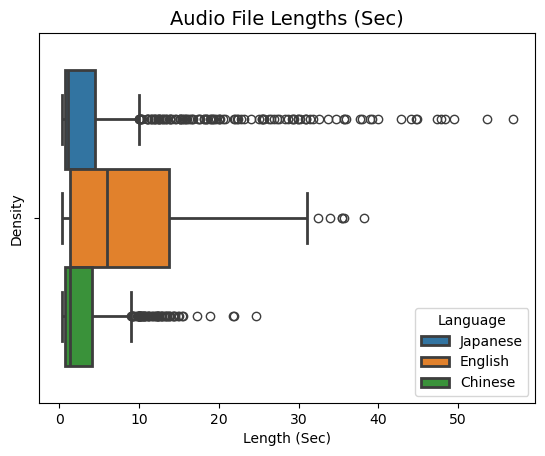

In [34]:
sns.boxplot(data=spreds, x="Length (Sec)", hue="Language", fill=True, linewidth=2)
plt.title("Audio File Lengths (Sec)", fontsize=14)
plt.xlabel("Length (Sec)")
plt.ylabel("Density")
plt.show()

To rectify this, all audio files under 1 second have been excluded, which are most likely non-linguistic utterances (coughs etc.) upon examination of the transcripts. Then, I sampled audio files from each language to balance the distribution and total time for each language.

In [35]:
# Remove recordings under 1 second and over 25 seconds if Japanese or Chinese
spreds_clean = spreds.query("`Length (Sec)` >= 1").copy()

# Sample recordings to get equal amounts of data based on length bins: 0-2 seconds, 2-4 seconds, 4-10 seconds, 10-20 seconds
def sample(df, random_state):
    df = df.copy()
    duration_bins = [0, 2, 4, 10, 20]
    bin_labels = ['Short', 'Medium', 'Long', 'Longest']
    df['Duration_Group'] = pd.cut(
        df['Length (Sec)'], 
        bins=duration_bins, 
        labels=bin_labels, 
        right=False
    )
    # Find the minimum count across all groups
    group_counts = df.groupby(['Language', 'Duration_Group'], observed=True).size().reset_index(name='Count')
    MIN_SAMPLES_PER_STRATA = group_counts['Count'].min()
    # Sample based on minimum count
    df = (
        df.groupby(['Language', 'Duration_Group'], observed=True)
        .sample(n=MIN_SAMPLES_PER_STRATA, random_state=random_state)
        .reset_index(drop=True)
    )
    return df

# Print metadata for one sample
sample_df = sample(spreds_clean, random_state=42)
print(f"Dataframe shape: {sample_df.shape}")
for lang in ['Japanese', 'English', 'Chinese']:
    x = sample_df.query(f"Language == '{lang}'")
    print(f"Number of {lang} observations: {x.shape[0]}. Total audio time: {sum(x['Length (Sec)'])} seconds")

Dataframe shape: (288, 7)
Number of Japanese observations: 96. Total audio time: 562.649 seconds
Number of English observations: 96. Total audio time: 577.216 seconds
Number of Chinese observations: 96. Total audio time: 568.748 seconds


Total audio time is now approximately even between languages, though there are only 288 total observations now. To address this and prevent possible biases for a single sample, I've sampled the original dataframe repeatedly and calculated summary statistics for the summary statistics of these samples.

In [36]:
# Target columns
summary_columns = [
    "Spectral Centroid Mean (Hz)",
    "Spectral Centroid STD (Hz)",
    "Spectral Bandwidth Mean (Hz)",
    "Spectral Bandwidth STD (Hz)",
]

# Function to calculate summary stats
def analyze_sample(df):
    """Sample and calculate means for each feature for each language"""
    sampled_df = sample(df, random_state=None) # None for true random, 42 for reproduction 
    summary = sampled_df.groupby('Language')[summary_columns].mean().reset_index()
    return summary

# Sample multiple times and get aggregate feature stats
n_iterations = 100
all_results = []
for i in range(n_iterations):
    result = analyze_sample(spreds_clean)
    all_results.append(result)

# Combine
spreds_agg = pd.concat(all_results, ignore_index=True)
spreds_agg.head()

,Language,Spectral Centroid Mean (Hz),Spectral Centroid STD (Hz),Spectral Bandwidth Mean (Hz),Spectral Bandwidth STD (Hz)
0,Chinese,2217.106935,1310.244129,2125.272043,674.946238
1,English,2029.908757,1262.491600,2095.351773,701.309882
2,Japanese,1606.418142,870.316080,1941.685356,626.075842
3,Chinese,2308.481102,1391.287760,2160.159247,705.080942
4,English,2041.483752,1256.975021,2098.473761,697.413267


In [37]:
# Variables to summarize

def Lower_bound(x):
    return np.percentile(x, 2.5)

def Upper_bound(x):
    return np.percentile(x, 97.5)

# Create dataframe for summary values
summary_stats = spreds_agg.groupby('Language')[summary_columns].agg([
    'mean',
    Lower_bound,
    Upper_bound
])

summary_stats

Spectral Centroid Mean (Hz)                            \
                                mean  Lower_bound  Upper_bound   
Language                                                         
Chinese                  2234.577192  2185.541019  2300.370491   
English                  2046.271169  2011.964994  2079.613973   
Japanese                 1621.432848  1567.666851  1676.206191   

         Spectral Centroid STD (Hz)                            \
                               mean  Lower_bound  Upper_bound   
Language                                                        
Chinese                 1355.371872  1300.893341  1409.792017   
English                 1271.484488  1249.117831  1298.402343   
Japanese                 887.564899   840.072012   937.529543   

         Spectral Bandwidth Mean (Hz)                            \
                                 mean  Lower_bound  Upper_bound   
Language                                                          
Chinese                   2136.450393  2108.374094  2166.932818   
English                   2102.694554  2078.271797  2124.498354   
Japanese                  1946.265390  1910.669181  1987.098835   

         Spectral Bandwidth STD (Hz)                          
                                mean Lower_bound Upper_bound  
Language                                                      
Chinese                   695.595378  676.424507  716.837741  
English                   706.951296  698.894593  716.210822  
Japanese                  634.801761  610.881558  658.475119

### Initial Analysis & Visualization

To visualize, I chose to use KDE plots for visual clarity, plotting spreds_agg to get the best look at the data when controlled for total length of time (amount of data).

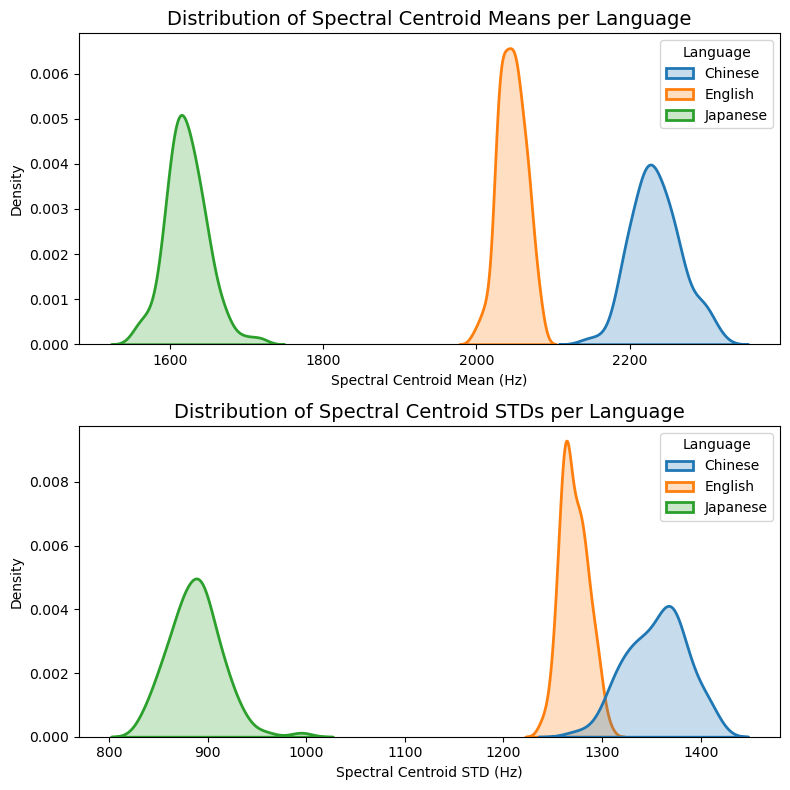

In [38]:
#Spectral Centroid
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(8, 8))
# Means
sns.kdeplot(data=spreds_agg, x="Spectral Centroid Mean (Hz)", hue="Language", ax=ax1, fill=True, linewidth=2)
ax1.set_title("Distribution of Spectral Centroid Means per Language", fontsize=14)
ax1.set_xlabel("Spectral Centroid Mean (Hz)")
ax1.set_ylabel("Density")
# STDs
sns.kdeplot(data=spreds_agg, x="Spectral Centroid STD (Hz)", hue="Language", ax=ax2, fill=True, linewidth=2)
ax2.set_title("Distribution of Spectral Centroid STDs per Language", fontsize=14)
ax2.set_xlabel("Spectral Centroid STD (Hz)")
ax2.set_ylabel("Density")
# Display
plt.tight_layout()
plt.show()

**Spectral Centroid Mean:**
Each language displays a tight distribution of spectral centroid values, typically spanning 100-200 Hz. Japanese has the lowest distribution centered at ~1623 Hz, with English and Chinese substantially higher. The three distributions show minimal overlap, suggesting distinct acoustic profiles. All appear normally distributed, though Chinese shows slight right skew.

**Spectral Centroid Standard Deviation:**
The pattern of variability follows the same ordering as the means. Japanese shows the lowest standard deviations, English is intermediate, and Chinese displays the highest. Only English and Chinese distributions overlap (around 1300 Hz), while Japanese remains distinct.

**Interpretation:**
- Japanese speech exhibits lower spectral centroids on average, suggesting less perceived vocal brightness and potentially more low-frequency energy or back vowels
- English and Chinese, particularly Chinese, show greater within-language variability in spectral centroids (higher standard deviations), which may reflect a wider range of vowel qualities or prosodic variation
- The minimal overlap between language distributions suggests spectral centroid could be a useful acoustic feature for distinguishing these languages

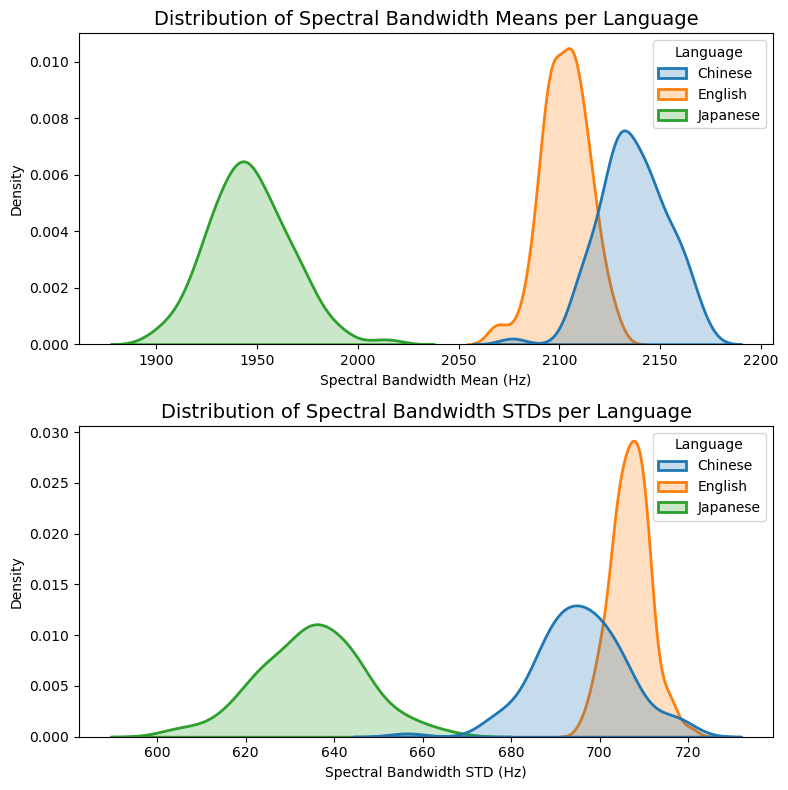

In [39]:
#Spectral Bandwidth
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(8, 8))
# Means
sns.kdeplot(data=spreds_agg, x="Spectral Bandwidth Mean (Hz)", hue="Language", ax=ax1, fill=True, linewidth=2)
ax1.set_title("Distribution of Spectral Bandwidth Means per Language", fontsize=14)
ax1.set_xlabel("Spectral Bandwidth Mean (Hz)")
ax1.set_ylabel("Density")
# STDs
sns.kdeplot(data=spreds_agg, x="Spectral Bandwidth STD (Hz)", hue="Language", ax=ax2, fill=True, linewidth=2)
ax2.set_title("Distribution of Spectral Bandwidth STDs per Language", fontsize=14)
ax2.set_xlabel("Spectral Bandwidth STD (Hz)")
ax2.set_ylabel("Density")
# Display
plt.tight_layout()
plt.show()

**Spectral Bandwidth Mean:**
Each language displays a greater spread in distribution of spectral bandwidth values, typically spanning ~1000 Hz. Japanese has the lowest distribution centered at ~1946 Hz, with English and Chinese being  higher. English and Chinese show considerable overlap, with Japanese having a much more distinctive acoustic profile. All appear normally distributed.

**Spectral Bandwidth Standard Deviation:**
The Japanese distribution is once again considerably lower than English or Chinese, though its spread is much greater and left skewed, leadeing to slight overlap with Chinese. The English distribution displays the tightest spread and is higher than Chinese, contrary to their mean distributions, though they still overlap considerably.

**Interpretation:**
- Japanese speech displays lower spectral bandwidth, meaning frequencies are more conentrated around the centroid than English or Chinese, suggesting a lower diversity of frequencies overall.
- English and Chinese speech once again overlap considerably, suggesting an overall higher and similar range and diversity of prosodic variation or vowel qualities.

### Inference

The data presents, on the surface, compelling evidence that spectral centroid and bandwidth could be important distinguishing features between languages' phonologies. Since vowels are central to utterances, it's no surprise that languages having different sets of vowels might manifest in differences in spectral centroid and bandwidth distributions.

These differences in feature distributions are intriguing, but it is unclear if they are significant enough to be meaningful distinguishers between languages, to the point where language users might intuitively pick up on brightness or breadth of sound (represented in these features). My own intuition has pointed to distinguishing Chinese based on things represented by spectral centroid and bandwidth (though in a direction opposite to that suggested by the data), for example, and these data provide a unique opportunity to empirically test this. A guiding question thereby presents itself:

**To what extent are the distributions related to the spectral centroid and bandwidth statistics for English, Chinese, and Japanese significantly different? Do these differences reflect existing research?**

As my gut feeling might imply, my hypothesis is that all 3 these differ significantly.

Before choosing a significance test, it's necessary to evaluate the normality of these distributions with a Shapiro-Wilk Test:

In [40]:
# Testing normality of the distributions
for lang in ['Japanese', 'English', 'Chinese']:
    for column in summary_columns:
        dist = spreds_agg.query(f"Language == '{lang}'")[column]
        statistic, p_value = stats.shapiro(dist)
        print(f"{lang} {column} Shapiro-Wilk results: {statistic}, p-val: {p_value}")
        if p_value < 0.05:
            print("Unlikely to be normally distributed")

Japanese Spectral Centroid Mean (Hz) Shapiro-Wilk results: 0.9792456916244199, p-val: 0.11609129722173495
Japanese Spectral Centroid STD (Hz) Shapiro-Wilk results: 0.970794678368718, p-val: 0.02543676667896507
Unlikely to be normally distributed
Japanese Spectral Bandwidth Mean (Hz) Shapiro-Wilk results: 0.9888780537226644, p-val: 0.5750083563371716
Japanese Spectral Bandwidth STD (Hz) Shapiro-Wilk results: 0.9939069101366759, p-val: 0.9362554623940043
English Spectral Centroid Mean (Hz) Shapiro-Wilk results: 0.9878034471974017, p-val: 0.49382959759543055
English Spectral Centroid STD (Hz) Shapiro-Wilk results: 0.9848454541936218, p-val: 0.30953075893004944
English Spectral Bandwidth Mean (Hz) Shapiro-Wilk results: 0.9854238057051297, p-val: 0.3405868430666065
English Spectral Bandwidth STD (Hz) Shapiro-Wilk results: 0.9919256915025121, p-val: 0.8158163776750667
Chinese Spectral Centroid Mean (Hz) Shapiro-Wilk results: 0.9874900497319209, p-val: 0.47140049691421637
Chinese Spectral Cen

Since each of the 4 statistics for each language generates a p-value greater than 0.05, it's safe to assume each is normally distributed.

Using a one-way ANOVA is therefore a great choice to start testing the independence of these distributions between the languages, since it is designed to compare the means of 3+ normal distributions. This will indicate if any group differs significantly.

In [41]:
# ANOVA
for column in summary_columns:
    dists = []
    for lang in ['Japanese', 'English', 'Chinese']:
        dists.append(spreds_agg.query(f"Language == '{lang}'")[column])
    f_stat, p_value = stats.f_oneway(dists[0], dists[1], dists[2])
    print(f"{column} ANOVA results: {f_stat}, p-val: {p_value}")

Spectral Centroid Mean (Hz) ANOVA results: 14136.220158398133, p-val: 3.183650938040436e-295
Spectral Centroid STD (Hz) ANOVA results: 10257.44758342249, p-val: 8.611042370681451e-275
Spectral Bandwidth Mean (Hz) ANOVA results: 3785.066087788923, p-val: 4.737948905321776e-212
Spectral Bandwidth STD (Hz) ANOVA results: 1710.212179209024, p-val: 1.0552974413470602e-163


The ANOVA generates extremely small p-values (much less than 0.05) for each feature distribution, indicating there is at least one significant difference for each.

Following up with a post-hoc Tukey's test can shed light on these differences.

In [42]:
for column in summary_columns:
    tukey = pairwise_tukeyhsd(endog=spreds_agg[f'{column}'], 
                            groups=spreds_agg['Language'], 
                            alpha=0.05)
    print(f"TUKEY SUMMARY FOR {column}")
    print(tukey)

TUKEY SUMMARY FOR Spectral Centroid Mean (Hz)
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2   meandiff p-adj   lower     upper   reject
-----------------------------------------------------------
Chinese  English  -188.306   0.0  -197.106  -179.506   True
Chinese Japanese -613.1443   0.0 -621.9443 -604.3444   True
English Japanese -424.8383   0.0 -433.6383 -416.0383   True
-----------------------------------------------------------
TUKEY SUMMARY FOR Spectral Centroid STD (Hz)
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2   meandiff p-adj   lower     upper   reject
-----------------------------------------------------------
Chinese  English  -83.8874   0.0  -92.0913  -75.6835   True
Chinese Japanese  -467.807   0.0 -476.0109  -459.603   True
English Japanese -383.9196   0.0 -392.1235 -375.7157   True
-----------------------------------------------------------
TUKEY SUMMARY FOR Spectral Bandwidth Mean (Hz)
    Multiple Compariso

The output confirms that each difference in mean for each pairwise comparison in each feature is significant, i.e. all distributions are significantly different from each other. This confirms the interpretation of the distribution visualizations. From this Tukey test, we can confidently say:
- Japanese features lower means on all measures compared to English and Chinese
- English and Chinese are much closer in spectral bandwidth and centroid than Japanese
- Languages are much more distinct in spectral centroid than bandwidth

The data used were, in my opinion, well controlled for potential environmental variation; each interview was conducted on similar topics with similar equipment. I attempted to minimize additional biases as much as possible by repeatedly and randomly selecting audio files based on bins of length, but there are other factors about the data that could prevent generalization. Each language only had a handful of speakers, meaning idiosyncratic variation in vocal quality could have a great effect on the realization of spectral centroid and bandwidth. If one or two speakers tended to speak with a large degree of hypersibilance or have a lisp, spectral centroid and bandwidth would increase without regard for their language's vowel system, for instance. 

Despite potential variation that couldn't be controlled for, the results I got were statistically significant, answering my first question; there are significant differences between Japanese, English, and Chinese in terms of their aggregate spectral centroid and bandwidth features. While the results contradicted my initial hypothesis that Chinese would be lowest in terms of these features (or at least spectral centroid), they do align with existing research. Out of these languages, Japanese has the least diversity of vowels (only 5 distinct ones), while English has the most (can be up to 20), which explains why Japanese is so far down in terms of spectral bandwidth mean and centroid STD. Of Japanese's vowels, 3 are back vowels, whose lower pitch explains a lower spectral centroid mean distribution. Chinese, as a tonal language, has a subsequent high degree of pitch variety, which would explain why it has high distributions for spectral bandwidth mean and centroid STD. 

### Prediction

How can these features - spectral centroid and bandwidth means and standard deviations - best be used to predict the language of the audio file?

Since the data is fairly straightforward, with only 4 continuous quantitative features and 3 classes and minimal overlap in feature distributions, I chose to compare two different prediction models: k-nearest neighbors classification and multinomial logistic regression. K-nearest neighbors classifies observations based on how close its features are to observations that are already classified, while logistic regression weighs features and generates the probability an observation belongs to a given class in a linear fashion.

I chose to assess the accuracy of each model with 4-fold cross-validation via scikit learn's cross validaiton score, which also returns an estimate of accuracy (number of correct predictions/number of predictions), as well as this score for each model's performance on the holdout sets.

In [43]:
# Data split
X = spreds[summary_columns].values
Y = spreds['Language'].values
X_train, X_holdout, Y_train, Y_holdout = train_test_split(
    X, Y, 
    test_size=0.2, # 20% to avoid missing a language in test split
    random_state=42, # Reproducibility
    stratify=Y  # Ensures balanced language distribution
)

# Scale features (for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

# Predictive models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42), # Default is multinomial
}

# Assessment of models via k-fold cross-validation
print("Cross-Validation Results:")
print("-" * 50)
results = {}
for name, model in models.items():
    # 4-fold cross-validation with stratification
    scores = cross_val_score(model, X_train_scaled, Y_train, cv=4, scoring='accuracy')
    results[name] = {
        'mean_accuracy': scores.mean(),
        'std': scores.std()
    }
    print(f"{name}: {scores.mean():.3f} (+/- {scores.std():.3f})")

# Final evaluation on holdout set
print("\nFinal Holdout Set Evaluation:")
print("-"*50)
for name, model in models.items():
    model.fit(X_train_scaled, Y_train)
    holdout_score = model.score(X_holdout_scaled, Y_holdout)
    print(f"{name} holdout accuracy: {holdout_score:.3f}")

Cross-Validation Results:
--------------------------------------------------
KNN: 0.773 (+/- 0.009)
Logistic Regression: 0.731 (+/- 0.009)

Final Holdout Set Evaluation:
--------------------------------------------------
KNN holdout accuracy: 0.793
Logistic Regression holdout accuracy: 0.733


In both the cross-validation and holdout set assessment, K-nearest neighbors was the more accurate model, with a 77.3% accuracy in cross-validation and 79.3% accuracy in the holdout. Logistic regression saw a 73.1% accuracy and 73.3% accuracy respectively. More detail can illuminate how each model performed for each language:

In [44]:
# Detailed model reports
for name, model in models.items():    
    y_pred = model.predict(X_holdout_scaled)
    print(f"\n{name} Classification Report:")
    print(classification_report(Y_holdout, y_pred))


KNN Classification Report:
              precision    recall  f1-score   support

     Chinese       0.79      0.81      0.80       185
     English       0.65      0.49      0.56        45
    Japanese       0.82      0.86      0.84       156

    accuracy                           0.79       386
   macro avg       0.75      0.72      0.73       386
weighted avg       0.79      0.79      0.79       386


Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Chinese       0.70      0.82      0.76       185
     English       0.00      0.00      0.00        45
    Japanese       0.77      0.85      0.81       156

    accuracy                           0.73       386
   macro avg       0.49      0.55      0.52       386
weighted avg       0.65      0.73      0.69       386



C:\Users\jacob\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jacob\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jacob\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Looking at the detailed metrics for each model on each language, we can see that Chinese and Japanese saw the most consistent and accurate predictions from the models. Regression had high recall for these languages but much lower precision (i.e. it found similar numbers of Chinese/Japanese files but is less accurate in identifying them correctly). English saw by far the lowest of all the metrics, which is unsurprising due to the low number of English files relatively to Chinese/Japanese (45 compared to 185 and 156) and English's spectral bandwidth metrics overlapping somewhat with Chinese. This was especially evident in the logistic regression model, where English saw 0 for precision, recall, and f1. The model never predicted English for any of the holdout, which likely resulted from having too few English samples overall and in the holdout set.

For this predictive task I am weighting false positives (precision) and negatives (recall) equally, as neither error type is more costly than the other in this context. Because f1 takes both precision and recall into account, I chose to use it as the main metric to select which model is best for prediction language based on spectral features. Since the KNN model had the highest f1 for all languages, as well as the highest overall accuracies, I would select it as the most appropriate predictive model.

What value should the number of neighbors be? To assess potential KNN models, we can assess the accuracy of KNN models with different numbers of neighbors:

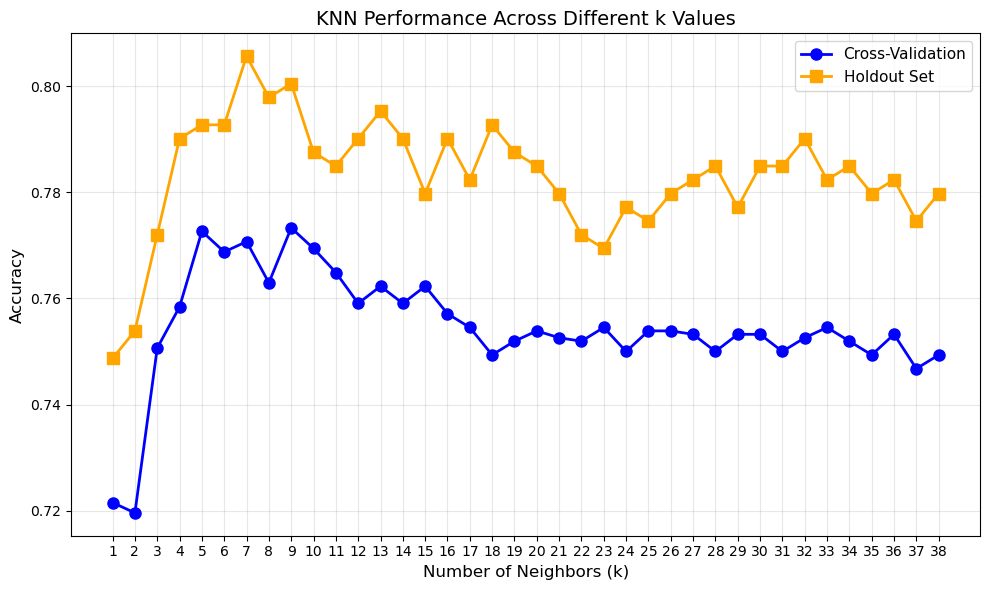

In [45]:
Cross = []
Holdout = []
Ks = range(1,int(np.sqrt(len(X_train)))) # num of neighbors from 1 to the sqrt of the length of the training set

def eval_KNN(model, cv):
    """
    Generates accuracy score via 4-fold cross-validation with stratification
    for a model
    """
    scores = cross_val_score(model, X_train_scaled, Y_train, cv=cv, scoring='accuracy')
    Cross.append(scores.mean())

# Assessment of models via k-fold cross-validation and holdout set for a range of neighbors
for i in Ks:
    model = KNeighborsClassifier(n_neighbors=i)
    eval_KNN(model, 4) # 4 folds for cross-validation
    model.fit(X_train_scaled, Y_train)
    Holdout.append(model.score(X_holdout_scaled, Y_holdout))

# Visualize KNN models' accuracy in k-fold cross-validation and holdout
plt.figure(figsize=(10, 6))
plt.plot(Ks, Cross, marker='o', label='Cross-Validation', 
         linewidth=2, markersize=8, color='blue')
plt.plot(Ks, Holdout, marker='s', label='Holdout Set', 
         linewidth=2, markersize=8, color='orange')
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('KNN Performance Across Different k Values', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(Ks)
plt.tight_layout()
plt.show()

From visualizing the performance of each k for a k-nearest neighbors, we can observe that:
- Predictive accuracy peaks at k=5 and k=9 for cross-validation
- Predictive accuracy peaks at k=7 for the holdout set
- Accuracy for both the holdout set and cross-validation falls off after 9

Therefore, selecting a **k-nearest neighbors model where k=9** seems to be the optimal method of predicting language based on spectral features. 

I would use this model to predict whether or not given audio is Chinese or Japanese. Due to the relative lack of English files in the dataset, despite similar lengths of audio for each language, I would not use this model to predict if a file is in English. To improve this model, I would want to find a dataset with an equal and large number of files in all 3 languages and train it on that.